In [16]:
# ─────────────────────────────  imports  ─────────────────────────────
import os, glob, warnings, numpy as np, pandas as pd, matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")

# ───────────────────────────  config  ────────────────────────────────
RAW_FOLDER, LOOK_BACK, FORECAST_HORIZON, FREQ = "Raw Data", 50, 15, "30s"
MIN_SEQUENCE_LEN, VELOCITY_FEATURE, TIME_FEATURES = 100, True, True

# ────────────────────────  data utilities  ───────────────────────────
def load_data():
    csvs = sorted(glob.glob(os.path.join(RAW_FOLDER, "*.csv")))
    if not csvs:
        raise FileNotFoundError(f"No CSVs in {RAW_FOLDER}")

    frames = []
    for p in csvs:
        df = pd.read_csv(p)

        # detect columns
        cols = {c.lower(): c for c in df.columns}
        t = next((cols[k] for k in cols if any(x in k for x in ("time","date"))), None)
        la = next((cols[k] for k in cols if "lat" in k), None)
        lo = next((cols[k] for k in cols if any(x in k for x in ("lon","long"))), None)
        if not (t and la and lo):
            continue

        df = df[[t, la, lo]].rename(columns={t: "TIME", la: "LAT", lo: "LONG"})
        df["TIME"] = pd.to_datetime(df["TIME"], errors="coerce")
        df["TIME"] = df["TIME"].dt.tz_localize(None)   # strip tz if present
        df = df.dropna().set_index("TIME").sort_index()
        if len(df) < MIN_SEQUENCE_LEN:
            continue

        for ax in ("LAT", "LONG"):                     # 3‑σ filter
            m, s = df[ax].mean(), df[ax].std()
            df = df[np.abs(df[ax] - m) < 3*s]

        frames.append(df)

    if not frames:
        raise ValueError("No usable data")

    return (
        pd.concat(frames)
          .sort_index()
          .loc[lambda x: ~x.index.duplicated()]
    )

def add_features(df):
    out = df.copy()

    if VELOCITY_FEATURE:
        dt = out.index.to_series().diff().dt.total_seconds().fillna(method="bfill").clip(lower=1)
        out["VEL_LAT"]  = out["LAT"].diff().div(dt) * 3600
        out["VEL_LONG"] = out["LONG"].diff().div(dt) * 3600
        out["SPEED"]    = np.sqrt(out["VEL_LAT"]**2 + out["VEL_LONG"]**2)

    if TIME_FEATURES:
        out["HOUR"]        = out.index.hour / 24
        out["DAY_OF_WEEK"] = out.index.dayofweek / 7
        out["MONTH"]       = out.index.month / 12

    return out.fillna(method="bfill").fillna(method="ffill")

# ───────────────────────  model wrapper  ─────────────────────────────
class EnhancedGPSPredictor:
    def __init__(self, lb=LOOK_BACK, hz=FORECAST_HORIZON):
        self.lb, self.hz = lb, hz
        self.x_scaler, self.y_scaler = StandardScaler(), StandardScaler()
        self.features, self.model = [], None

    def _build(self, n_feat):
        m = tf.keras.Sequential([
            tf.keras.layers.LSTM(128, return_sequences=True, input_shape=(self.lb, n_feat)),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.LSTM(64, return_sequences=True), tf.keras.layers.Dropout(0.3),
            tf.keras.layers.LSTM(32), tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(64, activation="relu"), tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(32, activation="relu"),
            tf.keras.layers.Dense(self.hz*2), tf.keras.layers.Reshape((self.hz,2)),
        ])
        m.compile("adam", loss="huber", metrics=["mae"])
        return m

    def make_xy(self, df):
        self.features = ["LAT", "LONG"] \
                      + (["VEL_LAT", "VEL_LONG", "SPEED"] if VELOCITY_FEATURE else []) \
                      + (["HOUR","DAY_OF_WEEK","MONTH"]  if TIME_FEATURES    else [])
        X_raw = df[self.features].values
        y_raw = df[["LAT","LONG"]].values
        Xn, yn = self.x_scaler.fit_transform(X_raw), self.y_scaler.fit_transform(y_raw)

        X, y = [], []
        rng = len(df) - self.lb - self.hz + 1
        for i in range(rng):
            X.append(Xn[i:i+self.lb]); y.append(yn[i+self.lb:i+self.lb+self.hz])
        return np.array(X), np.array(y)

    def train(self, X, y, epochs=5, val_split=0.15):
        n_feat = X.shape[-1]
        self.model = self._build(n_feat)
        s = int(len(X)*(1-val_split))
        hist = self.model.fit(
            X[:s], y[:s], validation_data=(X[s:], y[s:]),
            epochs=epochs, batch_size=64, verbose=1,
            callbacks=[
                tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
                tf.keras.callbacks.ReduceLROnPlateau(patience=5, factor=0.5),
            ])
        return hist

    def predict_denorm(self, X):
        y_hat = self.model.predict(X)
        shp = y_hat.shape
        return self.y_scaler.inverse_transform(y_hat.reshape(-1,2)).reshape(shp)

# ─────────────────────────────  run()  ───────────────────────────────
def run():
    df   = load_data()
    df   = df.resample(FREQ).mean().interpolate("time", limit=10).dropna()
    df_f = add_features(df)

    if len(df_f) < (LOOK_BACK+FORECAST_HORIZON)*3:
        raise RuntimeError("Not enough data")

    model = EnhancedGPSPredictor()
    X, y  = model.make_xy(df_f)
    split = int(len(X)*0.85)

    hist  = model.train(X[:split], y[:split], epochs=5)
    y_hat = model.predict_denorm(X[split:])
    y_true= model.y_scaler.inverse_transform(y[split:].reshape(-1,2)).reshape(y_hat.shape)

    return dict(hist=hist, y_hat=y_hat, y_true=y_true,
                df_f=df_f, split=split, X=X)

# ────────────────────────────  script  ───────────────────────────────
if __name__ == "__main__":
    res = run()     # now safe to call your plotting cell


Epoch 1/5
343/343 ━━━━━━━━━━━━━━━━━━━━ 55s 120ms/step - loss: 0.1357 - mae: 0.3505 - val_loss: 0.0093 - val_mae: 0.1129 - learning_rate: 0.0010
Epoch 2/5
343/343 ━━━━━━━━━━━━━━━━━━━━ 41s 119ms/step - loss: 0.0144 - mae: 0.1190 - val_loss: 0.0027 - val_mae: 0.0611 - learning_rate: 0.0010
Epoch 3/5
343/343 ━━━━━━━━━━━━━━━━━━━━ 44s 127ms/step - loss: 0.0110 - mae: 0.1052 - val_loss: 0.0042 - val_mae: 0.0788 - learning_rate: 0.0010
Epoch 4/5
343/343 ━━━━━━━━━━━━━━━━━━━━ 43s 125ms/step - loss: 0.0090 - mae: 0.0963 - val_loss: 0.0020 - val_mae: 0.0499 - learning_rate: 0.0010
Epoch 5/5
343/343 ━━━━━━━━━━━━━━━━━━━━ 43s 125ms/step - loss: 0.0082 - mae: 0.0905 - val_loss: 0.0033 - val_mae: 0.0669 - learning_rate: 0.0010
143/143 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step


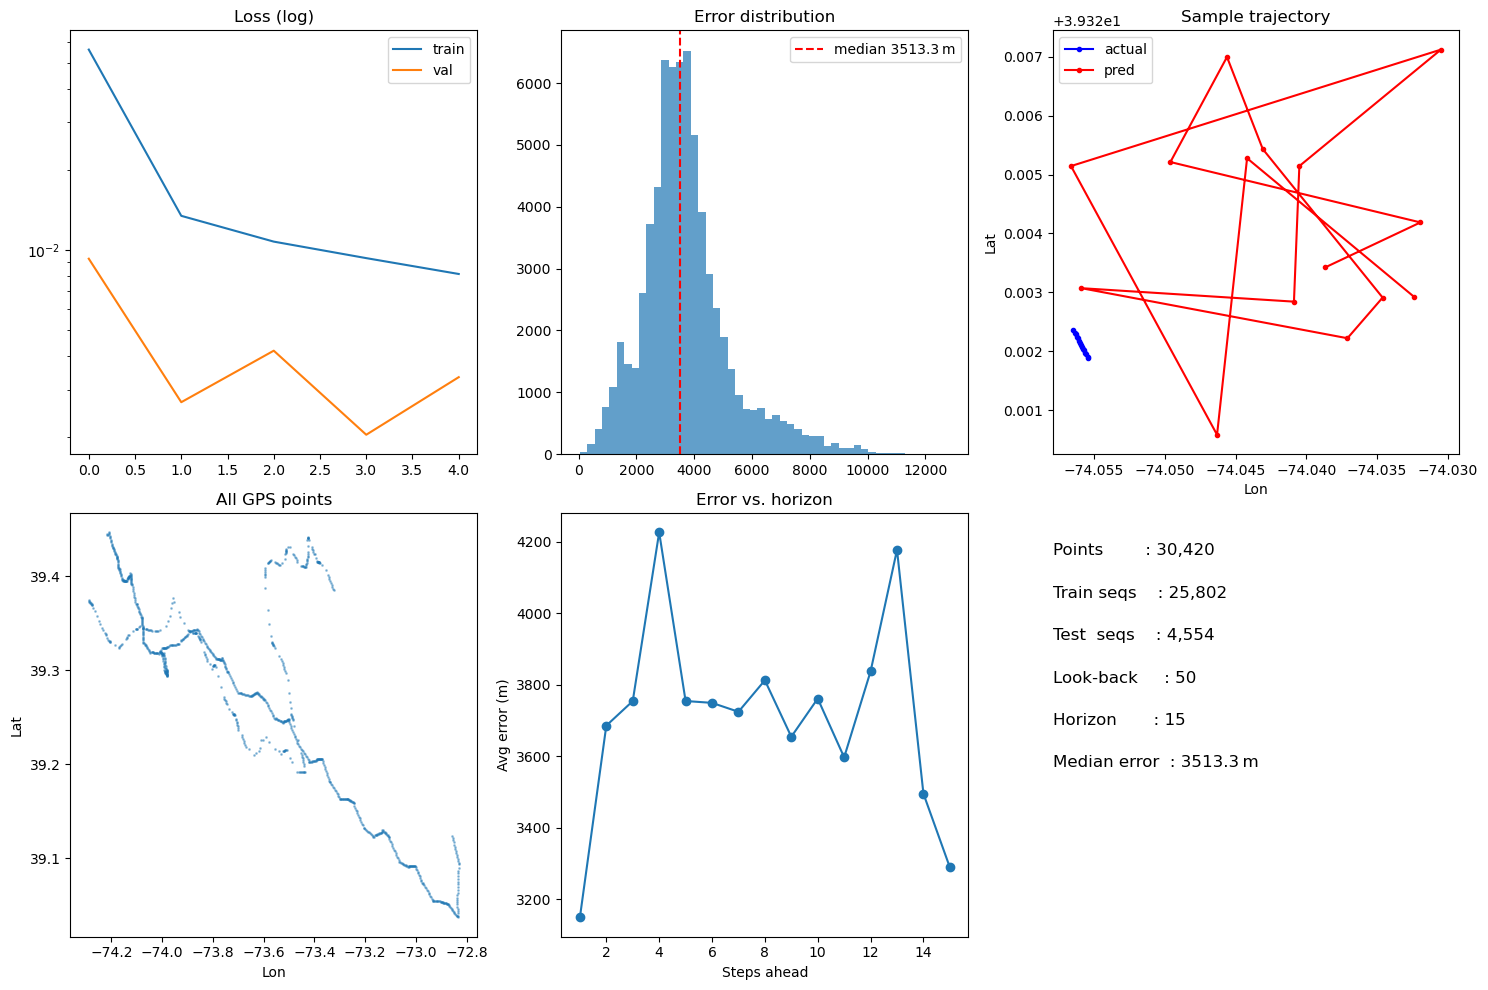

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# ------------------------------------------------------------------ helpers
def step_errors(y_true, y_pred):
    """Haversine error per prediction step (m)."""
    lat1, lon1 = np.radians(y_true[..., 0]), np.radians(y_true[..., 1])
    lat2, lon2 = np.radians(y_pred[..., 0]), np.radians(y_pred[..., 1])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 6371000 * 2 * np.arcsin(np.sqrt(a.clip(0, 1)))      # (samples, steps)

# ------------------------------------------------------------------ pull vars
hist        = res["hist"]            # training history
y_true      = res["y_true"]          # (samples, steps, 2)
y_pred      = res["y_hat"]
df_feat     = res["df_f"]            # feature‑augmented dataframe
split_idx   = res["split"]
X           = res["X"]
X_train, X_test = X[:split_idx], X[split_idx:]

step_err    = step_errors(y_true, y_pred)          # same shape as y_true
all_err     = step_err.ravel()

# ------------------------------------------------------------------ plots
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

# 1  loss
ax[0, 0].plot(hist.history["loss"],     label="train")
ax[0, 0].plot(hist.history["val_loss"], label="val")
ax[0, 0].set_title("Loss (log)")
ax[0, 0].set_yscale("log")
ax[0, 0].legend()

# 2  error histogram
ax[0, 1].hist(all_err, bins=50, alpha=.7)
ax[0, 1].axvline(np.median(all_err), c="r", ls="--",
                 label=f"median {np.median(all_err):.1f} m")
ax[0, 1].set_title("Error distribution")
ax[0, 1].legend()

# 3  one trajectory
s = 0
ax[0, 2].plot(y_true[s, :, 1], y_true[s, :, 0], "bo-", ms=3, label="actual")
ax[0, 2].plot(y_pred[s, :, 1], y_pred[s, :, 0], "ro-", ms=3, label="pred")
ax[0, 2].set_title("Sample trajectory")
ax[0, 2].set_xlabel("Lon"); ax[0, 2].set_ylabel("Lat")
ax[0, 2].legend()

# 4  full track (down‑sampled for speed)
sub = df_feat.iloc[::max(1, len(df_feat)//1000)]
ax[1, 0].scatter(sub["LONG"], sub["LAT"], s=1, alpha=.4)
ax[1, 0].set_title("All GPS points")
ax[1, 0].set_xlabel("Lon"); ax[1, 0].set_ylabel("Lat")

# 5  horizon vs avg error
avg_step = step_err.mean(axis=0)
ax[1, 1].plot(range(1, len(avg_step)+1), avg_step, "o-")
ax[1, 1].set_title("Error vs. horizon")
ax[1, 1].set_xlabel("Steps ahead"); ax[1, 1].set_ylabel("Avg error (m)")

# 6  summary
ax[1, 2].axis("off")
info = [
    f"Points        : {len(df_feat):,}",
    f"Train seqs    : {len(X_train):,}",
    f"Test  seqs    : {len(X_test):,}",
    f"Look‑back     : {LOOK_BACK}",
    f"Horizon       : {FORECAST_HORIZON}",
    f"Median error  : {np.median(all_err):.1f} m",
]
for i, line in enumerate(info):
    ax[1, 2].text(0, .9 - i*.1, line, fontsize=12)

plt.tight_layout(); plt.show()
